# Capstone Project - The Battle of The Neighborhoods (Week 2)

__Autor:__ Julio Guerrero

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Introduction: Background](#background)
* [Data](#data)
* [Results](#results)
* [Discussions](#discussions)
* [Conclusions](#conclusions)


## Introduction: Business Problem <a name="introduction"></a>

The aim of the project is to be able to cluster different areas of the City of Chicago so to label them based on their nearby venues and contrast these findings with the percentage of the population fully vaccinated. 

It´s logical to think that the faster everyone gets vaccinated, the faster the city can go to pre-pandemic movement. This can only be done by vaccinating more people. Having local outbreaks pushes local officials to impose restrictions and regulations that can be detrimental to stores and venues. While many US states are closing in at become fully vaccinated, having the full picture of this reality in number is important so investors can make inform decisions. This makes areas with higher vaccination more desirable for possible investor.

This project can help features venues owners or investors see which area is better suited for their type of venues, while helping them understand the risk of suffering local outbreaks and lose money because of it. 


## Introduction: Background <a name="background"></a>

The city of Chicago, located in the state of Illinois, is one of the most populated cities in the U.S, with an estimated population of 2,693,976 people. It also has one of the biggest GDP in the world, $689 Billion in 2018 [(1)](https://en.wikipedia.org/wiki/Chicago). The city can be divided in many ways. The two main ways this is done for data collection is by: Zip codes or Community Areas. There is map that shows in datil how this boundaries are drawn [(2)](https://www.chicago.gov/content/dam/city/sites/covid/reports/2020-04-24/ChicagoCommunityAreaandZipcodeMap.pdf).

All the data in this project will be from datasets organized by Zip Codes. It is important to note that there are a couple of Zip Codes that encompass areas that are outside city limits (Example: Zip Code 60827).

As many US Cities, Chicago economy suffers because of the pandemic. Strick Government lockdowns, aim at controlling the epidemic, produced grated unemployment. This can be attributed to many Chicago-Area business closing their doors as the pandemic went on [(3)](https://www.chicagotribune.com/coronavirus/ct-coronavirus-chicago-economy-six-months-20200917-ao6ngj2e5janndwjsfbkbmzss4-story.html). This makes the risk of future lookdowns a very real threat for venues owners. 

__Main Libraries use__

In [1]:
#This part is for the libraries that may need instalation

In [2]:
import pandas as pd #For usign DataFrames

import folium #To create Maps

import requests #For making web requests

#import json 

import numpy as np # For arrays




#For clustering
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

#For visualization of the results 
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

## Data <a name="data"></a>

The city of Chicago has a vast amount of Data on their official web page. The information that will be using will be:

1.	A GeoJSON file with the Zip Codes boundaries of the City of Chicago. This will be used for visualization of the data collected. [(4)](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw)
2.	A Dataset of the City of Chicago Data Portal call “COVID-19 Vaccine Doses by ZIP Code - Series Completed”.  We are interested in the percentage of the population fully vaccinated by zip code and the coordinates of the area. [(5)](https://data.cityofchicago.org/Health-Human-Services/COVID-19-Vaccine-Doses-by-ZIP-Code-Series-Complete/8u6c-48j3)
3.	We will use the Foursquare API to get the most common venues of each Zip Code.

We will use the coordinates of the second Dataset as the center of our search for venues using the Foursquare API. We will organize this information by Zip Code so to use it for clustering each Zip Code center. Using the data of the percentage of people fully vaccinated by zip code, we will make a choropleth map making use of the GeoJSON file. After clustering each zip code center, we will plot each point that map. 


First we load de csv file

In [3]:
df = pd.read_csv("COVID-19_Vaccinations_by_ZIP_Code.csv")
df.head()

Zip Code        Date  Total Doses - Daily  Total Doses - Cumulative  \
0    60601  04/09/2021                  323                     10259   
1    60601  04/10/2021                  210                     10469   
2    60601  04/11/2021                  123                     10592   
3    60601  04/12/2021                  208                     10800   
4    60601  04/13/2021                  314                     11114   

   1st Dose - Daily  1st Dose - Cumulative  1st Dose - Percent Population  \
0               228                   6908                          0.458   
1               153                   7061                          0.468   
2                84                   7145                          0.474   
3               119                   7264                          0.482   
4               159                   7423                          0.492   

   Vaccine Series Completed - Daily  Vaccine Series Completed - Cumulative  \
0                               131                                   3679   
1                                92                                   3771   
2                                67                                   3838   
3                               117                                   3955   
4                               155                                   4110   

   Vaccine Series Completed  - Percent Population  ...  \
0                                           0.244  ...   
1                                           0.250  ...   
2                                           0.254  ...   
3                                           0.262  ...   
4                                           0.272  ...   

   Total Doses - Daily - Age 65+  1st Dose - Daily - Age 12+  \
0                             13                         228   
1                              5                         153   
2                              1                          84   
3                              5                         119   
4                              9                         159   

   1st Dose - Daily - Age 18+  1st Dose - Daily - Age 65+  \
0                         228                           4   
1                         150                           2   
2                          83                           1   
3                         119                           2   
4                         159                           1   

   Vaccine Series Completed - Daily - Age 12+  \
0                                         131   
1                                          92   
2                                          67   
3                                         117   
4                                         155   

   Vaccine Series Completed - Daily - Age 18+  \
0                                         131   
1                                          92   
2                                          66   
3                                         117   
4                                         155   

   Vaccine Series Completed - Daily - Age 65+  Population  \
0                                           9       15083   
1                                           4       15083   
2                                           1       15083   
3                                           4       15083   
4                                           8       15083   

              ZIP Code Location          Row_ID  
0  POINT (-87.622844 41.886262)  60601-20210409  
1  POINT (-87.622844 41.886262)  60601-20210410  
2  POINT (-87.622844 41.886262)  60601-20210411  
3  POINT (-87.622844 41.886262)  60601-20210412  
4  POINT (-87.622844 41.886262)  60601-20210413  

[5 rows x 22 columns]

We will start to clean the data.For know we are interested in the Zip Codes and their location. The Dataset has many entries by date, so we first need to extract the important information. 

In [4]:
zip_codes = df["Zip Code"].unique() # Makes a list with all de Zip Codes in the Data
zip_codes

array(['60601', '60602', '60603', '60604', '60605', '60606', '60607',
       '60608', '60609', '60610', '60611', '60612', '60613', '60614',
       '60615', '60616', '60617', '60618', '60619', '60620', '60621',
       '60622', '60623', '60624', '60625', '60626', '60628', '60629',
       '60630', '60631', '60632', '60633', '60634', '60636', '60637',
       '60638', '60639', '60640', '60641', '60642', '60643', '60644',
       '60645', '60646', '60647', '60649', '60651', '60652', '60653',
       '60654', '60655', '60656', '60657', '60659', '60660', '60661',
       '60707', '60827', 'Unknown', '60666'], dtype=object)

We will drop all rows that are have "Unknown"  as zip code

In [5]:
df = df[df["Zip Code"]!="Unknown"]

We will extract the zip codes, their population, their coordinates and the percentage of people fully vaccinated  to make a knew dataframe

In [6]:
codes_info={}
for code in zip_codes:
    arr_population = df[df["Zip Code"]==code]["Population"].unique() #Array with the values of population, this to chekc for singel value on all rows
    arr_location = df[df["Zip Code"]==code]["ZIP Code Location"].unique()
    if (len(arr_population) == 1 and len(arr_location ==1)):
        split = arr_location[0].split(" ")
        lat = float(split[2].replace(")",""))
        lon = float(split[1].replace("(",""))
        pop_vac =df[df["Zip Code"]==code]["Vaccine Series Completed  - Percent Population"].unique().max()
        if pop_vac > 1:
            pop_vac =1
        codes_info[code]=[arr_population[0],lat,lon,round(pop_vac,3)*100]
    else:
        print("Problem with the zip code: ", code)#This will be printed if one zip codes has more than one population value or location
    
codes_info   

Problem with the zip code:  Unknown


{'60601': [15083, 41.886262, -87.622844, 67.60000000000001],
 '60602': [1145, 41.883136, -87.628309, 95.8],
 '60603': [1052, 41.880112, -87.625473, 100],
 '60604': [823, 41.878153, -87.629029, 88.3],
 '60605': [29060, 41.867824, -87.623449, 64.8],
 '60606': [3287, 41.882634, -87.63676, 84.7],
 '60607': [29293, 41.876104, -87.652727, 62.4],
 '60608': [80059, 41.849879, -87.670366, 55.2],
 '60609': [60939, 41.812017, -87.653382, 46.5],
 '60610': [40548, 41.90455, -87.63581, 60.0],
 '60611': [33224, 41.894734, -87.620291, 70.5],
 '60612': [33735, 41.88004, -87.687011, 44.2],
 '60613': [50761, 41.953742, -87.661343, 66.2],
 '60614': [71954, 41.922605, -87.652064, 58.8],
 '60615': [40590, 41.801993, -87.602725, 54.50000000000001],
 '60616': [54197, 41.844869, -87.629531, 54.900000000000006],
 '60617': [83553, 41.721257, -87.556897, 37.7],
 '60618': [94907, 41.946699, -87.703343, 56.599999999999994],
 '60619': [61207, 41.744737, -87.60569, 37.0],
 '60620': [67711, 41.740873, -87.651656, 34.4

Know with will make a new DataFrame to have all the infromation by Zip code in one dataFrame

In [7]:
df_zip = pd.DataFrame.from_dict(codes_info,orient="index")
df_zip.reset_index(inplace=True)
df_zip.columns=["Zip Code","Population","Latitude","Longitude","Vaccine Series Completed-Percent Population"]
print("Shape: ",df_zip.shape)
df_zip.head()

Shape:  (59, 5)


Zip Code  Population   Latitude  Longitude  \
0    60601       15083  41.886262 -87.622844   
1    60602        1145  41.883136 -87.628309   
2    60603        1052  41.880112 -87.625473   
3    60604         823  41.878153 -87.629029   
4    60605       29060  41.867824 -87.623449   

   Vaccine Series Completed-Percent Population  
0                                         67.6  
1                                         95.8  
2                                        100.0  
3                                         88.3  
4                                         64.8

We check for null values and the format of the columns

In [8]:
df_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 5 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Zip Code                                     59 non-null     object 
 1   Population                                   59 non-null     int64  
 2   Latitude                                     59 non-null     float64
 3   Longitude                                    59 non-null     float64
 4   Vaccine Series Completed-Percent Population  59 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.4+ KB


Know we will use folium and a GeoJSON (with the boundaries of the zip codes areas) file to make markers of the locations of the zip codes

In [9]:
url ="Boundaries_Chicago.geojson"

chicago_coor = [41.881832,-87.623177]
zoom = 10 #10 is the best value to show the zip codes
map_chicago = folium.Map(location=chicago_coor, zoom_start = zoom)


#folium.Marker(chicago_coor,popup="<b>Chicago City Center<b>",tooltip="Clic me!").add_to(map_chicago)
folium.GeoJson(url,name="geojson").add_to(map_chicago)

for code,lat,lon in zip(df_zip["Zip Code"],df_zip["Latitude"],df_zip["Longitude"]):
    folium.Marker([lat,lon],popup= code,tooltip=code).add_to(map_chicago)
map_chicago

map_chicago

If you look closely at the map it will seem that there are some markers out of place or Zip Codes areas without a marker. This is because there are zip codes areas that go outside city limits and the GeoJSON file only use the parts of the area that, are legally, of the city of Chicago. Therefore, those markers are out of place. 

We will let this marker be the center of out Zip codes for now.

#### Foursquare API

With the coordinates of each Zip Code Center, we will use the foursquare API to search for the nearby venues. For this we will make a new dataframe with information on each Venue

In [14]:
Client_id = "[]"
Client_secret = '[]'
Version = "20180605"
Limit = 100

In [15]:
# this funtion will return a Data frame with information about venues nearby
def getNearbyVenues(names, latitudes, longitudes, radius=950):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes): # this will check all the neighborhoods in names
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            Client_id, 
            Client_secret, 
            Version, 
            lat, 
            lng, 
            radius, 
            Limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip Code', 
                  'Zip Code Latitude', 
                  'Zip Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)     

In [16]:
chicago_venues = getNearbyVenues(df_zip["Zip Code"],df_zip["Latitude"],df_zip["Longitude"])

In [17]:
chicago_venues

Zip Code  Zip Code Latitude  Zip Code Longitude  \
0       60601          41.886262          -87.622844   
1       60601          41.886262          -87.622844   
2       60601          41.886262          -87.622844   
3       60601          41.886262          -87.622844   
4       60601          41.886262          -87.622844   
...       ...                ...                 ...   
3478    60666          41.979511          -87.896371   
3479    60666          41.979511          -87.896371   
3480    60666          41.979511          -87.896371   
3481    60666          41.979511          -87.896371   
3482    60666          41.979511          -87.896371   

                            Venue  Venue Latitude  Venue Longitude  \
0     Chicago Architecture Center       41.887720       -87.623650   
1       Roti Modern Mediterranean       41.886048       -87.624948   
2       Wildberry Pancakes & Cafe       41.884412       -87.623047   
3                      sweetgreen       41.884964       -87.624728   
4                St. Jane Chicago       41.886573       -87.624902   
...                           ...             ...              ...   
3478                        Tocco       41.975227       -87.891488   
3479               American Eagle       41.973338       -87.903236   
3480     Southwest Airlines - ORD       41.976667       -87.892265   
3481                    Starbucks       41.981114       -87.906329   
3482                Gaslight Club       41.977610       -87.904794   

                Venue Category  
0                Tour Provider  
1     Mediterranean Restaurant  
2               Breakfast Spot  
3                  Salad Place  
4                        Hotel  
...                        ...  
3478        Italian Restaurant  
3479           Airport Service  
3480          Airport Terminal  
3481               Coffee Shop  
3482                Steakhouse  

[3483 rows x 7 columns]

We make a DataFrame so to count the amount of venues each Zip Codes Centers has nearby to make a plot

In [18]:
df_aux  = chicago_venues.groupby("Zip Code").count().sort_values(by=["Zip Code Latitude"])
df_aux

Zip Code Latitude  Zip Code Longitude  Venue  Venue Latitude  \
Zip Code                                                                 
60827                     5                   5      5               5   
60617                    15                  15     15              15   
60644                    18                  18     18              18   
60633                    18                  18     18              18   
60628                    20                  20     20              20   
60616                    21                  21     21              21   
60643                    22                  22     22              22   
60636                    22                  22     22              22   
60609                    22                  22     22              22   
60656                    23                  23     23              23   
60638                    24                  24     24              24   
60621                    24                  24     24              24   
60651                    26                  26     26              26   
60637                    26                  26     26              26   
60620                    28                  28     28              28   
60655                    29                  29     29              29   
60646                    30                  30     30              30   
60707                    33                  33     33              33   
60612                    34                  34     34              34   
60641                    34                  34     34              34   
60629                    35                  35     35              35   
60652                    36                  36     36              36   
60624                    38                  38     38              38   
60639                    39                  39     39              39   
60631                    39                  39     39              39   
60634                    40                  40     40              40   
60645                    40                  40     40              40   
60653                    42                  42     42              42   
60623                    43                  43     43              43   
60619                    46                  46     46              46   
60632                    47                  47     47              47   
60649                    50                  50     50              50   
60630                    56                  56     56              56   
60615                    56                  56     56              56   
60618                    57                  57     57              57   
60608                    76                  76     76              76   
60659                    84                  84     84              84   
60625                    85                  85     85              85   
60626                   100                 100    100             100   
60654                   100                 100    100             100   
60660                   100                 100    100             100   
60602                   100                 100    100             100   
60657                   100                 100    100             100   
60661                   100                 100    100             100   
60666                   100                 100    100             100   
60603                   100                 100    100             100   
60604                   100                 100    100             100   
60607                   100                 100    100             100   
60647                   100                 100    100             100   
60606                   100                 100    100             100   
60642                   100                 100    100             100   
60610                   100                 100    100             100   
60640         

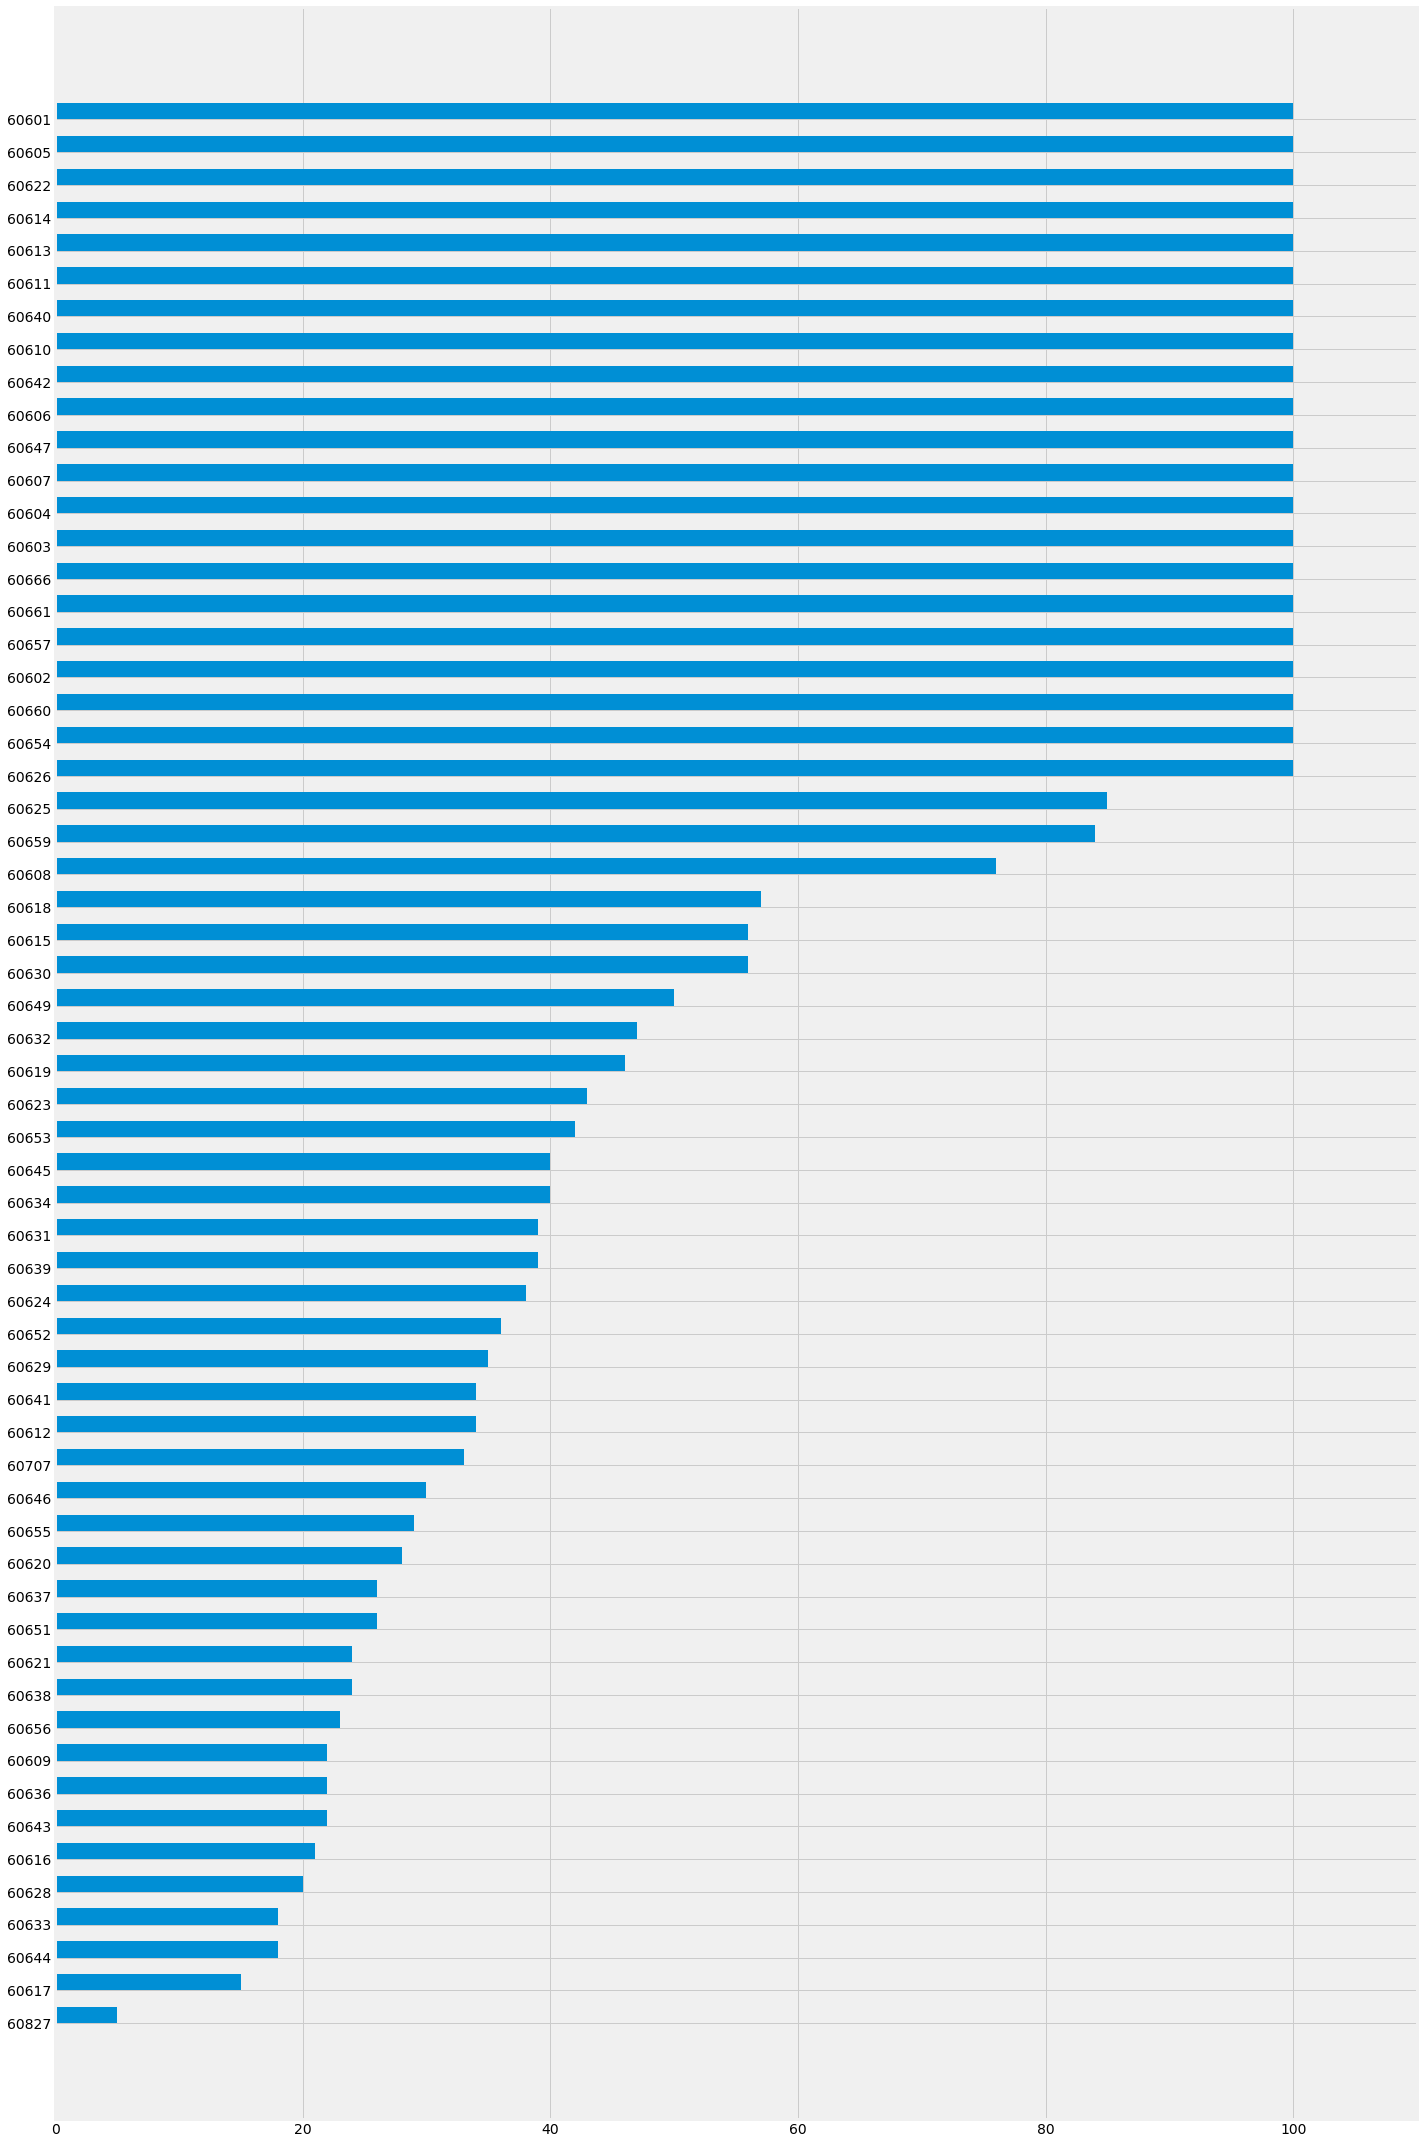

In [19]:
#Make a histogram of the venues
#%matplotlib inline
plt.figure(figsize=(20,30))
plt.style.use("fivethirtyeight")

plt.barh(df_aux.index,df_aux["Venue Category"],align="edge",height=.5)


plt.xlim(0,110)
plt.tight_layout()
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()


There are venues with less than 100 venues. This does not mean that those are all the venues in that Zip Code area. This is likely the effect of the coordinates that the Zip Code center is located. It is possible that in larger Zip Codes Areas the denser venues sections are not close to the center.

We will use the one hot encode method on each category type. 

In [20]:
chicago_onehot = pd.get_dummies(chicago_venues[["Venue Category"]],prefix="",prefix_sep="")
print("Number of unique categories: ", len(chicago_venues["Venue Category"].unique()))
chicago_onehot.insert(0,"Zip Code",chicago_venues["Zip Code"])
chicago_onehot

Number of unique categories:  326


Zip Code  ATM  Accessories Store  Adult Boutique  African Restaurant  \
0       60601    0                  0               0                   0   
1       60601    0                  0               0                   0   
2       60601    0                  0               0                   0   
3       60601    0                  0               0                   0   
4       60601    0                  0               0                   0   
...       ...  ...                ...             ...                 ...   
3478    60666    0                  0               0                   0   
3479    60666    0                  0               0                   0   
3480    60666    0                  0               0                   0   
3481    60666    0                  0               0                   0   
3482    60666    0                  0               0                   0   

      Airport  Airport Lounge  Airport Service  Airport Terminal  \
0           0               0                0                 0   
1           0               0                0                 0   
2           0               0                0                 0   
3           0               0                0                 0   
4           0               0                0                 0   
...       ...             ...              ...               ...   
3478        0               0                0                 0   
3479        0               0                1                 0   
3480        0               0                0                 1   
3481        0               0                0                 0   
3482        0               0                0                 0   

      American Restaurant  ...  Video Store  Vietnamese Restaurant  \
0                       0  ...            0                      0   
1                       0  ...            0                      0   
2                       0  ...            0                      0   
3                       0  ...            0                      0   
4                       0  ...            0                      0   
...                   ...  ...          ...                    ...   
3478                    0  ...            0                      0   
3479                    0  ...            0                      0   
3480                    0  ...            0                      0   
3481                    0  ...            0                      0   
3482                    0  ...            0                      0   

      Waterfront  Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  \
0              0           0         0          0       0            0   
1              0           0         0          0       0            0   
2              0           0         0          0       0            0   
3              0           0         0          0       0            0   
4              0           0         0          0       0            0   
...          ...         ...       ...        ...     ...          ...   
3478           0           0         0          0       0            0   
3479           0           0         0          0       0            0   
3480           0           0         0          0       0            0   
3481           0           0         0          0       0            0   
3482           0           0         0          0       0            0   

      Women's Store  Yoga Studio  
0                 0            0  
1                 0            0  
2                 0            0  
3                 0            0  
4                 0            0  
...             ...          ...  
3478              0            0  
3479              0            0  
3480              0            0  
3481              0            0  
3482              0            0  

[3483 rows x 327 columns]

For making a Data Frame for clustering we will calculate the mean of each category in each Zip Code

In [21]:
chicago_grouped = chicago_onehot.groupby("Zip Code").mean().reset_index()
chicago_grouped

Zip Code       ATM  Accessories Store  Adult Boutique  African Restaurant  \
0     60601  0.000000               0.00            0.00            0.000000   
1     60602  0.000000               0.00            0.00            0.000000   
2     60603  0.000000               0.00            0.00            0.000000   
3     60604  0.000000               0.00            0.00            0.000000   
4     60605  0.000000               0.00            0.00            0.000000   
5     60606  0.000000               0.00            0.00            0.000000   
6     60607  0.000000               0.00            0.00            0.000000   
7     60608  0.000000               0.00            0.00            0.000000   
8     60609  0.000000               0.00            0.00            0.000000   
9     60610  0.000000               0.00            0.00            0.000000   
10    60611  0.000000               0.00            0.00            0.000000   
11    60612  0.000000               0.00            0.00            0.000000   
12    60613  0.000000               0.00            0.00            0.000000   
13    60614  0.000000               0.01            0.00            0.000000   
14    60615  0.000000               0.00            0.00            0.017857   
15    60616  0.000000               0.00            0.00            0.000000   
16    60617  0.000000               0.00            0.00            0.000000   
17    60618  0.000000               0.00            0.00            0.000000   
18    60619  0.000000               0.00            0.00            0.043478   
19    60620  0.000000               0.00            0.00            0.000000   
20    60621  0.041667               0.00            0.00            0.000000   
21    60622  0.000000               0.01            0.00            0.000000   
22    60623  0.000000               0.00            0.00            0.000000   
23    60624  0.026316               0.00            0.00            0.000000   
24    60625  0.000000               0.00            0.00            0.000000   
25    60626  0.000000               0.00            0.00            0.010000   
26    60628  0.000000               0.00            0.00            0.000000   
27    60629  0.000000               0.00            0.00            0.000000   
28    60630  0.000000               0.00            0.00            0.000000   
29    60631  0.000000               0.00            0.00            0.000000   
30    60632  0.000000               0.00            0.00            0.000000   
31    60633  0.000000               0.00            0.00            0.000000   
32    60634  0.000000               0.00            0.00            0.000000   
33    60636  0.000000               0.00            0.00            0.000000   
34    60637  0.000000               0.00            0.00            0.000000   
35    60638  0.000000               0.00            0.00            0.000000   
36    60639  0.000000               0.00            0.00            0.000000   
37    60640  0.000000               0.00            0.01            0.000000   
38    60641  0.000000               0.00            0.00            0.000000   
39    60642  0.000000               0.01            0.00            0.000000   
40    60643  0.000000               0.00            0.00            0.000000   
41    60644  0.111111               0.00            0.00            0.000000   
42    60645  0.000000               0.00            0.00            0.000000   
43    60646  0.000000               0.00            0.00            0.000000   
44    60647  0.000000               0.00            0.00            0.000000   
45    60649  0.000000               0.00            0.00            0.000000   
46    60651  0.000000               0.00            0.00            0.000000   
47    60652  0.000000               0.00            0.00            0.000000   
48    60653  0.000000               0.00            0.00            0.000000   
49 

The following cell is to check the top Venue of each Zip Code and the frequency of them

In [22]:
num_top_venues = 5

for hood in chicago_grouped['Zip Code']:
    print("----"+hood+"----")
    temp = chicago_grouped[chicago_grouped['Zip Code'] == hood].T.reset_index() 
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]# the firs row will be Neighborhood| hood
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----60601----
                 venue  freq
0                Hotel  0.11
1  American Restaurant  0.04
2              Theater  0.04
3   Seafood Restaurant  0.04
4          Snack Place  0.03


----60602----
         venue  freq
0        Hotel  0.09
1      Theater  0.05
2       Museum  0.04
3  Coffee Shop  0.04
4   Steakhouse  0.04


----60603----
         venue  freq
0      Theater  0.06
1  Coffee Shop  0.06
2        Hotel  0.03
3  Pizza Place  0.03
4         Park  0.03


----60604----
                venue  freq
0               Hotel  0.06
1         Coffee Shop  0.05
2  Italian Restaurant  0.04
3    Asian Restaurant  0.03
4              Museum  0.03


----60605----
                  venue  freq
0           Pizza Place  0.04
1  Gym / Fitness Center  0.04
2              Aquarium  0.04
3           Yoga Studio  0.03
4          Burger Joint  0.03


----60606----
                     venue  freq
0              Coffee Shop  0.07
1                  Theater  0.05
2                    Hotel  0.05


4             Brewery  0.04


----60649----
                           venue  freq
0             Chinese Restaurant  0.06
1             Seafood Restaurant  0.06
2                    Coffee Shop  0.04
3  Vegetarian / Vegan Restaurant  0.04
4                         Bakery  0.04


----60651----
            venue  freq
0   Grocery Store  0.08
1  Clothing Store  0.08
2  Sandwich Place  0.08
3     Pizza Place  0.04
4    Home Service  0.04


----60652----
                 venue  freq
0          Pizza Place  0.08
1   Mexican Restaurant  0.08
2   Seafood Restaurant  0.06
3         Liquor Store  0.06
4  Fried Chicken Joint  0.06


----60653----
            venue  freq
0            Park  0.17
1       BBQ Joint  0.05
2  Discount Store  0.05
3      Food Truck  0.05
4   Train Station  0.05


----60654----
                     venue  freq
0       Italian Restaurant  0.10
1               Steakhouse  0.07
2                    Hotel  0.05
3                      Bar  0.05
4  New American Restaurant  0.0

Now we make a Data Frame with the top 10 most common Venues of each Zip Code.

In [23]:
def return_most_common_venues(row,num_top_venues):
    row_categories = row.iloc[1:]#The firts cell is the Zip code
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]


In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip Code']
for ind in np.arange(num_top_venues):#Loop to create the names of the columns for a new data frame
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
zip_code_venues_sorted = pd.DataFrame(columns=columns)
zip_code_venues_sorted["Zip Code"] = chicago_grouped["Zip Code"]

for ind in np.arange(chicago_grouped.shape[0]):
    zip_code_venues_sorted.iloc[ind,1:]= return_most_common_venues(chicago_grouped.iloc[ind,:],num_top_venues)
zip_code_venues_sorted.head()  

Zip Code 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0    60601                 Hotel               Theater    Seafood Restaurant   
1    60602                 Hotel               Theater                Museum   
2    60603               Theater           Coffee Shop           Pizza Place   
3    60604                 Hotel           Coffee Shop    Italian Restaurant   
4    60605           Pizza Place  Gym / Fitness Center              Aquarium   

  4th Most Common Venue 5th Most Common Venue      6th Most Common Venue  \
0   American Restaurant           Snack Place             Cosmetics Shop   
1            Steakhouse           Coffee Shop  Middle Eastern Restaurant   
2    Italian Restaurant                  Park                     Museum   
3        Sandwich Place                   Pub                     Museum   
4           Yoga Studio          Burger Joint                      Hotel   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Steakhouse           Pizza Place                  Park   
1    Seafood Restaurant                   Bar           Salad Place   
2           Salad Place                 Hotel          Concert Hall   
3           Salad Place                  Café      Asian Restaurant   
4        Sandwich Place            Taco Place      Sushi Restaurant   

  10th Most Common Venue  
0                    Bar  
1            Pizza Place  
2                 Garden  
3                Theater  
4         Breakfast Spot

### Clustering

Talk about K means clustering

The main parameter that needs to be tune is the number of clusters (also known as K). For this we train models with different values of K and use the dissimilarity between the clusters to measure their performance. With those values in function of K, we can plot the result and use the elbow method to determine the best value for k, as we did for the next graph.

In [25]:
chicago_grouped_clustering = chicago_grouped.drop("Zip Code",1)
#use the elbow method to determine the number of clusters need it

distortions = []
inertias = []

mapping1 = {}
mapping2 = {}
k =range(1,10)
for k in k:
   
    model = KMeans(init = "k-means++",n_init = 12,n_clusters=k,random_state=0).fit(chicago_grouped_clustering)
    
    a =sum(np.min(cdist(chicago_grouped_clustering,model.cluster_centers_,'euclidean'),axis=1))/chicago_grouped_clustering.shape[0]
    b =model.inertia_
    
    distortions.append(a)
    
    inertias.append(b)
    
    mapping1[k]=a
    
    mapping2[k]=b



In [26]:
chicago_grouped_clustering.shape

(59, 326)

In [27]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 0.1801522894156507
2 : 0.1716214669820128
3 : 0.1629583706804923
4 : 0.15666353497890656
5 : 0.1530065409170754
6 : 0.14694934661417822
7 : 0.14314190877652175
8 : 0.14049271171542618
9 : 0.13813090877510012


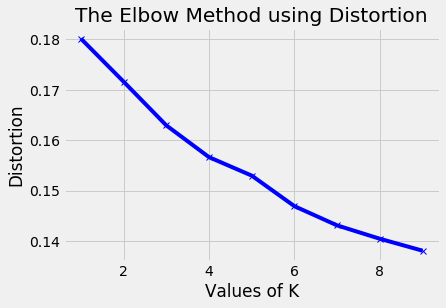

In [28]:
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

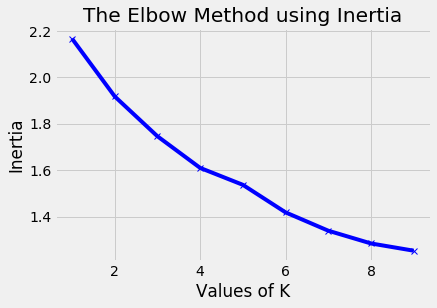

In [29]:

plt.plot(range(1,10), inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Even do there is not a clear elbow, the value of K equals 8 produced clusters with big enough number and sufficient difference between them that make us happy.

In [30]:

k=5
model = KMeans(n_clusters=k,random_state=0).fit(chicago_grouped_clustering)
model.labels_

array([1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       3, 0, 1, 0, 0, 3, 0, 1, 0, 3, 0, 0, 0, 0, 3, 1, 0, 1, 4, 4, 0, 4,
       1, 0, 0, 3, 4, 1, 0, 0, 1, 0, 1, 1, 1, 0, 2])

Next we introduce the labels in the main data frame we were using

In [33]:

#zip_code_venues_sorted.drop(columns=["Cluster Labels"],inplace=True) # This line is for teating only
#chicago_grouped.drop(columns=["Cluster Labels"],inplace=True)
zip_code_venues_sorted.insert(0,"Cluster Labels",model.labels_)#This data frame will be to know the frequency of each venue
chicago_grouped.insert(0,"Cluster Labels",model.labels_)



We Will group that data frame by Cluster label to know the size of each cluster.

In [34]:
df_aux = zip_code_venues_sorted.groupby(["Cluster Labels"]).count().reset_index()
df_aux

Cluster Labels  Zip Code  1st Most Common Venue  2nd Most Common Venue  \
0               0        26                     26                     26   
1               1        22                     22                     22   
2               2         1                      1                      1   
3               3         6                      6                      6   
4               4         4                      4                      4   

   3rd Most Common Venue  4th Most Common Venue  5th Most Common Venue  \
0                     26                     26                     26   
1                     22                     22                     22   
2                      1                      1                      1   
3                      6                      6                      6   
4                      4                      4                      4   

   6th Most Common Venue  7th Most Common Venue  8th Most Common Venue  \
0                     26                     26                     26   
1                     22                     22                     22   
2                      1                      1                      1   
3                      6                      6                      6   
4                      4                      4                      4   

   9th Most Common Venue  10th Most Common Venue  
0                     26                      26  
1                     22                      22  
2                      1                       1  
3                      6                       6  
4                      4                       4

In [35]:
list_single = list(df_aux[df_aux["Zip Code"]<2]["Cluster Labels"])#Create a list of all the cluster with only one item
list_single

[2]

In [36]:
labels_grouped = chicago_grouped.groupby("Cluster Labels").mean().reset_index()
labels_grouped.head()

Cluster Labels       ATM  Accessories Store  Adult Boutique  \
0               0  0.003941           0.000000        0.000000   
1               1  0.000000           0.002273        0.000455   
2               2  0.000000           0.000000        0.000000   
3               3  0.000000           0.000000        0.000000   
4               4  0.027778           0.000000        0.000000   

   African Restaurant   Airport  Airport Lounge  Airport Service  \
0            0.002744  0.003205        0.000000         0.000000   
1            0.000455  0.000455        0.003182         0.003182   
2            0.000000  0.000000        0.000000         0.000000   
3            0.000000  0.000000        0.000000         0.000000   
4            0.000000  0.000000        0.000000         0.000000   

   Airport Terminal  American Restaurant  ...  Video Store  \
0          0.003205             0.023138  ...     0.006266   
1          0.000455             0.020455  ...     0.000000   
2          0.000000             0.000000  ...     0.000000   
3          0.000000             0.018162  ...     0.006955   
4          0.000000             0.022727  ...     0.000000   

   Vietnamese Restaurant  Waterfront  Whisky Bar  Wine Bar  Wine Shop  \
0               0.000916    0.000000    0.000000  0.001479   0.000769   
1               0.008422    0.000909    0.002273  0.003182   0.004347   
2               0.000000    0.000000    0.000000  0.000000   0.000000   
3               0.000000    0.000000    0.002193  0.000000   0.000000   
4               0.008333    0.000000    0.000000  0.000000   0.000000   

     Winery  Wings Joint  Women's Store  Yoga Studio  
0  0.000000     0.006867       0.006226     0.000000  
1  0.000455     0.000455       0.002727     0.010080  
2  0.000000     0.000000       0.000000     0.000000  
3  0.000000     0.004762       0.000000     0.000000  
4  0.000000     0.000000       0.000000     0.011364  

[5 rows x 327 columns]

We will look at the most common venues on each cluster an their frequency.

In [37]:
num_top_venues = 5

print("Top "+str(k)+" Venues by cluster label")
for label in labels_grouped['Cluster Labels']:
    print("----"+str(label)+"----")
    temp = labels_grouped[labels_grouped['Cluster Labels'] == label].T.reset_index() 
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]# the firs row will be Neighborhood| hood
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
        

Top 5 Venues by cluster label
----0----
                  venue  freq
0  Fast Food Restaurant  0.05
1                  Park  0.04
2        Sandwich Place  0.04
3           Pizza Place  0.03
4    Mexican Restaurant  0.03


----1----
                venue  freq
0         Coffee Shop  0.05
1  Italian Restaurant  0.03
2         Pizza Place  0.03
3                 Bar  0.03
4               Hotel  0.03


----2----
          venue  freq
0   Pizza Place   0.4
1   Golf Course   0.2
2  Home Service   0.2
3   Coffee Shop   0.2
4           ATM   0.0


----3----
                venue  freq
0  Mexican Restaurant  0.16
1         Pizza Place  0.07
2      Discount Store  0.04
3                Park  0.03
4          Donut Shop  0.03


----4----
            venue  freq
0            Park  0.15
1   Grocery Store  0.06
2             ATM  0.03
3  Sandwich Place  0.03
4   Train Station  0.03




In [38]:
for n in list_single:
    Code=int(zip_code_venues_sorted[zip_code_venues_sorted["Cluster Labels"]==n]["Zip Code"])
    print("The only Zip Code in Cluster "+str(n)+" is: "+str(Code))
                                          


The only Zip Code in Cluster 2 is: 60827


We will name thes clusters  based on their top 5 venues, except the cluster with only one Area. 

__Cluster 0:__ Park and fast food (Red in the map)

__Cluster 1:__ Coffee and Italian food  (Purple in the map)

__Cluster 2:__ 60827 (Blue in the map)

__Cluster 3:__ Mexican Food and Pizza (Green in the map)

__Cluster 4:__ Parks and Grocery (Orange in the map)



The next data frame is the conclusion of this project

In [39]:
chicago_merged = df_zip

chicago_merged = chicago_merged.join(zip_code_venues_sorted.set_index("Zip Code"), on="Zip Code")
print(chicago_merged.shape)
chicago_merged.head()

(59, 16)


Zip Code  Population   Latitude  Longitude  \
0    60601       15083  41.886262 -87.622844   
1    60602        1145  41.883136 -87.628309   
2    60603        1052  41.880112 -87.625473   
3    60604         823  41.878153 -87.629029   
4    60605       29060  41.867824 -87.623449   

   Vaccine Series Completed-Percent Population  Cluster Labels  \
0                                         67.6               1   
1                                         95.8               1   
2                                        100.0               1   
3                                         88.3               1   
4                                         64.8               1   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                 Hotel               Theater    Seafood Restaurant   
1                 Hotel               Theater                Museum   
2               Theater           Coffee Shop           Pizza Place   
3                 Hotel           Coffee Shop    Italian Restaurant   
4           Pizza Place  Gym / Fitness Center              Aquarium   

  4th Most Common Venue 5th Most Common Venue      6th Most Common Venue  \
0   American Restaurant           Snack Place             Cosmetics Shop   
1            Steakhouse           Coffee Shop  Middle Eastern Restaurant   
2    Italian Restaurant                  Park                     Museum   
3        Sandwich Place                   Pub                     Museum   
4           Yoga Studio          Burger Joint                      Hotel   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Steakhouse           Pizza Place                  Park   
1    Seafood Restaurant                   Bar           Salad Place   
2           Salad Place                 Hotel          Concert Hall   
3           Salad Place                  Café      Asian Restaurant   
4        Sandwich Place            Taco Place      Sushi Restaurant   

  10th Most Common Venue  
0                    Bar  
1            Pizza Place  
2                 Garden  
3                Theater  
4         Breakfast Spot

We will use folium to make a choropleth map based on the percentage of the population fully vaccinated and mark each Area with a marker based on their cluster.

In [42]:
#Set color for scheme
x =np.arange(k) #k is the number of clusters
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

marker_colors = []
map_chicago = folium.Map(location=chicago_coor, zoom_start = zoom)

folium.Choropleth(
    geo_data="Boundaries_Chicago.geojson",
    name="choropleth",
    data=df_zip,
    columns=["Zip Code",'Vaccine Series Completed-Percent Population'],
    key_on='feature.properties.zip',
    fill_color="GnBu",
    legend_name ="People fully vaccinated "
    ).add_to(map_chicago)

for lat,lon,cod,lab,vac in zip(chicago_merged["Latitude"],chicago_merged["Longitude"],chicago_merged["Zip Code"],chicago_merged["Cluster Labels"],chicago_merged["Vaccine Series Completed-Percent Population"]):
    label = folium.Popup(str(cod) + ' Cluster:' + str(lab)+"\n"+str(round(vac,1))+"%", parse_html=True)
    folium.CircleMarker(
      [lat, lon],
            radius=5,
            popup=label,
            tooltip=cod,
            color=rainbow[lab-1],
            fill=True,
            fill_color=rainbow[lab-1],
            fill_opacity=0.7).add_to(map_chicago)  
    

    

In [43]:
map_chicago

## Results <a name="results"></a>

There seems to be that areas of cluster 1 (Coffee and Italian food, the purple dots) are closer to the city center. Also, this points area located in areas that are almost fully vaccinated. Cluster 0 (Park and fast food, red dots) seems to surround cluster 1, which may explain the higher frequency of parks.  

Cluster 4 (Parks and grocery) seems to be the one farther away of the city center, which may explain why it has more “convenient” types of foods and locals. The last cluster seems to have higher frequency of Mexican restaurants and pizza venues.

We also see that the closer we get to the city center, the higher the percentage of people fully vaccinated. It does not seem to be a correlation between our clusters and the percentage of people vaccinated. 


## Discussions <a name="discussions"></a>

This project could be complemented with more demographic information about the city of Chicago (as Per Capita Income and population density) so to give the stakeholders more information about what type of business is better suited for each area. This information is available in the Chicago Data portal, but the information is given by Community Areas. 

This project can be improved by dividing the city in smaller areas. An idea for this is to create hexagons around the city and give each one the data on the area they are located. That could solve the problem of having data that divided the city in a different way. After that each, hexagon can be cluster, as done in this project. This could improve the way we look at each section of the city.

The Zip Code 60666 belongs to the airport. Given that airports are very different from the normal areas of a city, is important that a stake holder how wants to target the airport looks for more specific information for that.

Because there is no clear elbow in the clustering section of the project, there is argument for using other type of clustering algorithm. We try to use DBSCAN but were unable to tune the parameters to produce good clusters. 


## Conclusions <a name="conclusions"></a>

We were able to group each Zip Code of the city in 5 clusters based on their venues. Whit that information we made a couple of data frames that can tell future investors which are the most common venues and their frequency. We also created a Map so to give an idea of the distribution of our clusters and the percentages of people fully vaccinated in the city of Chicago 